In [12]:
import os
import json
import torch
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from collections import Counter
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [13]:
# Configurations
DATA_DIR = './/data//dog-breed-identification'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
LABELS_FILE = os.path.join(DATA_DIR, 'labels.csv')
OUTPUT_DIR = './data/processed'

TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

IMG_SIZE = 224
BATCH_SIZE = 64
NUM_WORKERS = 4

BALANCE_STRATEGY = 'undersample'
TARGET_SAMPLES_PER_CLASS = None

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs('results/preprocessing', exist_ok=True)

In [14]:
# Load & prepare labels
labels_df = pd.read_csv(LABELS_FILE)
print(f"Loaded {len(labels_df)} images.")

breeds = sorted(labels_df['breed'].unique())
breed_to_idx = {breed: idx for idx, breed in enumerate(breeds)}
idx_to_breed = {idx: breed for breed, idx in breed_to_idx.items()}
print(f"Loaded {len(breeds)} unique breeds.")

labels_df['label'] = labels_df['breed'].map(breed_to_idx)

# Save mappings
with open(os.path.join(OUTPUT_DIR, 'breed_mappings.json'), 'w') as f:
    json.dump({
        'breed_to_idx': breed_to_idx,
        'idx_to_breed': idx_to_breed
    }, f, indent=2)
print(f"\nSaved breed mappings to {OUTPUT_DIR}/breed_mappings.json")

Loaded 10222 images.
Loaded 120 unique breeds.

Saved breed mappings to ./data/processed/breed_mappings.json


In [15]:
# Class balancing
breed_counts_before = labels_df['breed'].value_counts()

print(f"Before balancing:")
print(f"    Samples per breed - Min: {breed_counts_before.min()}, Max: {breed_counts_before.max()}, Mean: {breed_counts_before.mean():.1f}")

if BALANCE_STRATEGY == 'undersample':
    if TARGET_SAMPLES_PER_CLASS is None:
        target_count = int(breed_counts_before.median())
    else:
        target_count = TARGET_SAMPLES_PER_CLASS
    
    balanced_dfs = []
    for breed in breeds:
        breed_df = labels_df[labels_df['breed'] == breed]
        if len(breed_df) > target_count:
            breed_df = breed_df.sample(n=target_count, random_state=42)
        balanced_dfs.append(breed_df)
    
    labels_df = pd.concat(balanced_dfs, ignore_index=True)
    labels_df = labels_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
elif BALANCE_STRATEGY == 'oversample':
    if TARGET_SAMPLES_PER_CLASS is None:
        target_count = int(breed_counts_before.median())
    else:
        target_count = TARGET_SAMPLES_PER_CLASS
    
    balanced_dfs = []
    for breed in breeds:
        breed_df = labels_df[labels_df['breed'] == breed]
        if len(breed_df) < target_count:
            breed_df = breed_df.sample(n=target_count, replace=True, random_state=42)
        balanced_dfs.append(breed_df)
    
    labels_df = pd.concat(balanced_dfs, ignore_index=True)
    labels_df = labels_df.sample(frac=1, random_state=42).reset_index(drop=True)

breed_counts_after = labels_df['breed'].value_counts()
print(f"\nAfter balancing:")
print(f"    Total samples: {len(labels_df)}")
print(f"    Samples per breed - Min: {breed_counts_after.min()}, Max: {breed_counts_after.max()}, Mean: {breed_counts_after.mean():.1f}")

Before balancing:
    Samples per breed - Min: 66, Max: 126, Mean: 85.2

After balancing:
    Total samples: 9422
    Samples per breed - Min: 66, Max: 82, Mean: 78.5


In [16]:
# Stratified train/val/test split
train_val_df, test_df = train_test_split(
    labels_df,
    test_size=TEST_RATIO,
    stratify=labels_df['breed'],
    random_state=42
)

val_ratio_adjusted = VAL_RATIO / (TRAIN_RATIO + VAL_RATIO)
train_df, val_df = train_test_split(
    train_val_df,
    test_size=val_ratio_adjusted,
    stratify=train_val_df['breed'],
    random_state=42
)

print(f"Dataset splits:")
print(f"    Training:   {len(train_df):5d} samples ({len(train_df)/len(labels_df)*100:.1f}%)")
print(f"    Validation: {len(val_df):5d} samples ({len(val_df)/len(labels_df)*100:.1f}%)")
print(f"    Test:       {len(test_df):5d} samples ({len(test_df)/len(labels_df)*100:.1f}%)")

print(f"\nVerifying stratification (breeds per split):")
print(f"    Training:   {train_df['breed'].nunique()} breeds")
print(f"    Validation: {val_df['breed'].nunique()} breeds")
print(f"    Test:       {test_df['breed'].nunique()} breeds")

# Save splits
train_df.to_csv(os.path.join(OUTPUT_DIR, 'train_split.csv'), index=False)
val_df.to_csv(os.path.join(OUTPUT_DIR, 'val_split.csv'), index=False)
test_df.to_csv(os.path.join(OUTPUT_DIR, 'test_split.csv'), index=False)
print(f"\nSaved splits to {OUTPUT_DIR}/")

Dataset splits:
    Training:    6594 samples (70.0%)
    Validation:  1414 samples (15.0%)
    Test:        1414 samples (15.0%)

Verifying stratification (breeds per split):
    Training:   120 breeds
    Validation: 120 breeds
    Test:       120 breeds

Saved splits to ./data/processed/


In [17]:
# Define transforms

# ImageNet normalization statistics
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

print("Training transforms (with augmentation):")
print("- RandomResizedCrop(224, scale=0.8-1.0)")
print("- RandomHorizontalFlip(p=0.5)")
print("- RandomRotation(±15°)")
print("- ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)")
print("- Normalize (ImageNet stats)")

print("\nValidation/Test transforms:")
print("- Resize(256)")
print("- CenterCrop(224)")
print("- Normalize (ImageNet stats)")

Training transforms (with augmentation):
- RandomResizedCrop(224, scale=0.8-1.0)
- RandomHorizontalFlip(p=0.5)
- RandomRotation(±15°)
- ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
- Normalize (ImageNet stats)

Validation/Test transforms:
- Resize(256)
- CenterCrop(224)
- Normalize (ImageNet stats)


In [18]:
# Custom dataset class
class DogBreedDataset(Dataset):
    """Custom Dataset for Dog Breed Classification"""

    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_id = self.dataframe.loc[idx, 'id']
        label = self.dataframe.loc[idx, 'label']
        
        img_path = os.path.join(self.img_dir, f"{img_id}.jpg")
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [19]:
# Create datasets
train_dataset = DogBreedDataset(train_df, TRAIN_DIR, transform=train_transform)
val_dataset = DogBreedDataset(val_df, TRAIN_DIR, transform=val_test_transform)
test_dataset = DogBreedDataset(test_df, TRAIN_DIR, transform=val_test_transform)

print(f"Training:   {len(train_dataset)} samples")
print(f"Validation: {len(val_dataset)} samples")
print(f"Test:       {len(test_dataset)} samples")

Training:   6594 samples
Validation: 1414 samples
Test:       1414 samples


In [20]:
# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"Training batches:   {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches:       {len(test_loader)}")

Training batches:   104
Validation batches: 23
Test batches:       23


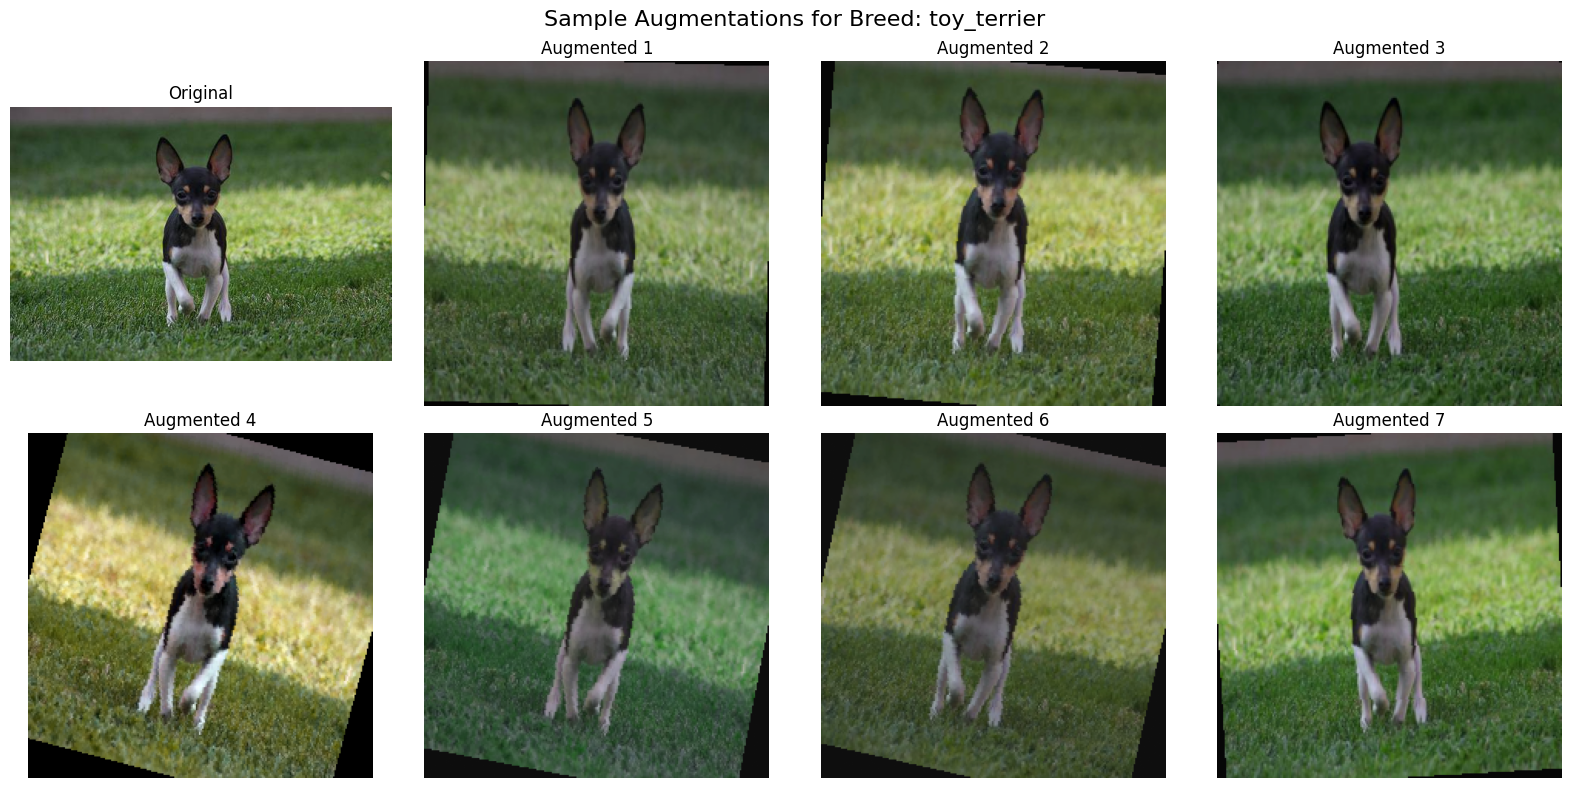

In [21]:
# Visualize sample augmentations
sample_idx = np.random.randint(0, len(train_df))
sample_id = train_df.iloc[sample_idx]['id']
sample_breed = train_df.iloc[sample_idx]['breed']
sample_img_path = os.path.join(TRAIN_DIR, f"{sample_id}.jpg")

original_img = Image.open(sample_img_path).convert('RGB')

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

axes[0].imshow(original_img)
axes[0].set_title("Original")
axes[0].axis('off')

for i in range(1, 8):
    augmented = train_transform(original_img)
    img_display = augmented.clone()

    for t, m, s in zip(img_display, IMAGENET_MEAN, IMAGENET_STD):
        t.mul_(s).add_(m)
    
    img_display = torch.clamp(img_display, 0, 1)
    img_display = img_display.permute(1, 2, 0).numpy()

    axes[i].imshow(img_display)
    axes[i].set_title(f"Augmented {i}")
    axes[i].axis('off')

fig.suptitle(f"Sample Augmentations for Breed: {sample_breed}", fontsize=16)
plt.tight_layout()

In [22]:
config = {
    'data_dir': DATA_DIR,
    'train_dir': TRAIN_DIR,
    'output_dir': OUTPUT_DIR,
    'img_size': IMG_SIZE,
    'batch_size': BATCH_SIZE,
    'num_workers': NUM_WORKERS,
    'train_ratio': TRAIN_RATIO,
    'val_ratio': VAL_RATIO,
    'test_ratio': TEST_RATIO,
    'balance_strategy': BALANCE_STRATEGY,
    'target_samples_per_class': TARGET_SAMPLES_PER_CLASS,
    'num_breeds': len(breeds),
    'train_samples': len(train_df),
    'val_samples': len(val_df),
    'test_samples': len(test_df),
    'imagenet_mean': IMAGENET_MEAN,
    'imagenet_std': IMAGENET_STD,
    'augmentation': {
        'random_resized_crop': {'size': IMG_SIZE, 'scale': [0.8, 1.0]},
        'random_horizontal_flip': {'p': 0.5},
        'random_rotation': {'degrees': 15},
        'color_jitter': {
            'brightness': 0.2,
            'contrast': 0.2,
            'saturation': 0.2,
            'hue': 0.1
        }
    }
}

with open(os.path.join(OUTPUT_DIR, 'preprocessing_config.json'), 'w') as f:
    json.dump(config, f, indent=2)